# Modelado de un sistema con ipython

Uso de ipython para el modelado de un sistema a partir de los datos obtenidos en un ensayo.

In [1]:
#Importamos las librerías utilizadas
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal

In [2]:
#Mostramos las versiones usadas de cada librerías
print ("Numpy v{}".format(np.__version__))
print ("Pandas v{}".format(pd.__version__))
print ("Seaborn v{}".format(sns.__version__))

Numpy v1.9.2
Pandas v0.16.2
Seaborn v0.6.0


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
#Abrimos el fichero csv con los datos de la muestra
datos = pd.read_csv('datos.csv')

In [5]:
#Almacenamos en una lista las columnas del fichero con las que vamos a trabajar
#columns = ['temperatura', 'entrada']
columns = ['temperatura', 'entrada']

## Representación

Representamos los datos mostrados en función del tiempo. De esta manera, vemos la respuesta física que tiene nuestro sistema. 

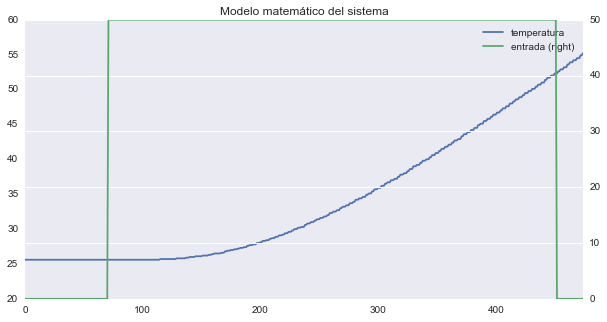

In [6]:
#Mostramos en varias gráficas la información obtenida tras el ensayo
datos[columns].plot(secondary_y=['entrada'],figsize=(10,5), ylim=(20,60),title='Modelo matemático del sistema')
#datos_filtrados['RPM TRAC'].plot(secondary_y=True,style='g',figsize=(20,20)).set_ylabel=('RPM')


##Cálculo del polinomio

Hacemos una regresión con un polinomio de orden 4 para calcular cual es la mejor ecuación que se ajusta a la tendencia de nuestros datos.

In [7]:
# Buscamos el polinomio de orden 4 que determina la distribución de los datos
reg = np.polyfit(datos['time'],datos['temperatura'],2)
# Calculamos los valores de y con la regresión
ry = np.polyval(reg,datos['time'])
print (reg)

[  8.18174358e-09  -1.57332539e-04   2.59458703e+01]


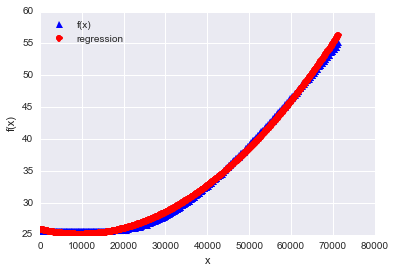

In [8]:
plt.plot(datos['time'],datos['temperatura'],'b^', label=('f(x)'))
plt.plot(datos['time'],ry,'ro', label=('regression'))
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')


El polinomio caracteristico de nuestro sistema es:

$$P_x=  25.9459 -1.5733·10^{-4}·X - 8.18174·10^{-9}·X^2$$

##Transformada de laplace

Si calculamos la transformada de laplace del sistema, obtenemos el siguiente resultado:

$$G_s = \frac{25.95·S^2 - 0.00015733·S + 1.63635·10^{-8}}{S^3}$$

In [10]:
##Respuesta en frecuencia del sistema 
num = [25.9459 ,0.00015733 ,0.00000000818174]
den = [1,0,0]
tf = signal.lti(num,den)
w, mag, phase = signal.bode(tf)

In [11]:
tf = signal.lti(num,den)
w, mag, phase = signal.bode(tf)

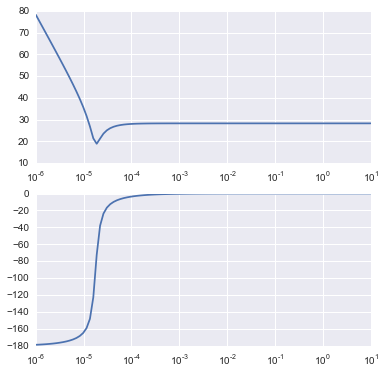

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
ax1.semilogx(w, mag) # Eje x logarítmico
ax2.semilogx(w, phase) # Eje x logarítmico

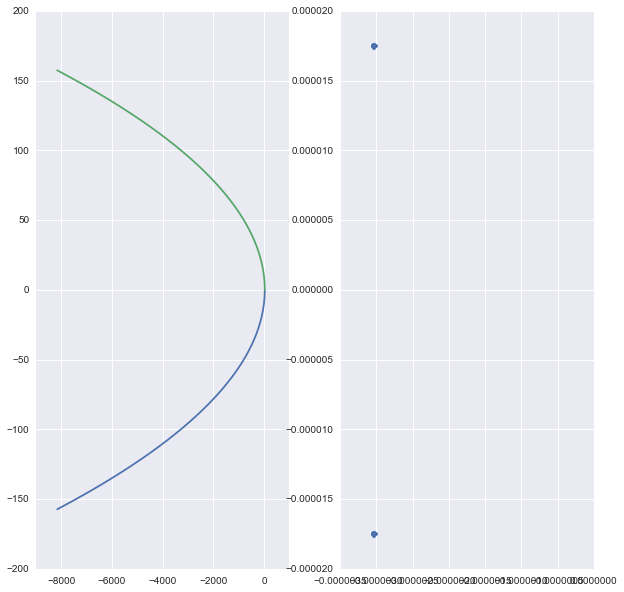

In [13]:
w, H = signal.freqresp(tf)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.plot(H.real, H.imag)
ax1.plot(H.real, -H.imag)
ax2.plot(tf.zeros.real, tf.zeros.imag, 'o')
ax2.plot(tf.poles.real, tf.poles.imag, 'x')

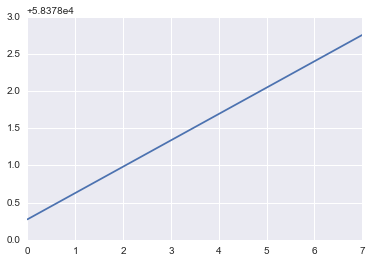

In [17]:
t, y = signal.step2(tf) # Respuesta a escalón unitario
plt.plot(t, 2250 * y) # Equivalente a una entrada de altura 2250

## Cálculo del PID mediante OCTAVE

Aplicando el método de sintonizacion de Ziegler-Nichols calcularemos el PID para poder regular correctamente el sistema. Esté método consiste en el cálculo de tres parámetros característicos, con los cuales calcularemos el regulador:

$$G_s=K_p(1+\frac{1}{T_i·S}+T_d·s)=K_p+\frac{K_i}{s}+K_d$$


El cálculo de los parámetros característicos del método, lo realizaremos con Octave, con el siguiente código:
~~~
pkg load control
H=tf([25.95 0.000157333 1.63635E-8],[1 0 0 0]);
step(H);
dt=0.150;
t=0:dt:65;
y=step(H,t);
dy=diff(y)/dt;
[m,p]=max(dy);
yi=y(p);
ti=t(p);
L=ti-yi/m
Tao=(y(end)-yi)/m+ti-L
Kp=1.2*Tao/L
Ti=2*L;
Td=0.5*L;
Ki=Kp/ti;
Kd=Kp*Td;
~~~

En esta primera iteración, los datos obtenidos son los siguientes:
$K_p = 6082.6$ $K_i=93.868 K_d=38.9262$

Con lo que nuestro regulador tiene la siguiente ecuación característica:

$$G_s = \frac{38.9262·S^2 + 6082.6·S + 93.868}{S}$$

In [23]:
#Almacenamos en una lista las columnas del fichero con las que vamos a trabajar
datos = pd.read_csv('Regulador1.csv')
columns = ['temperatura']

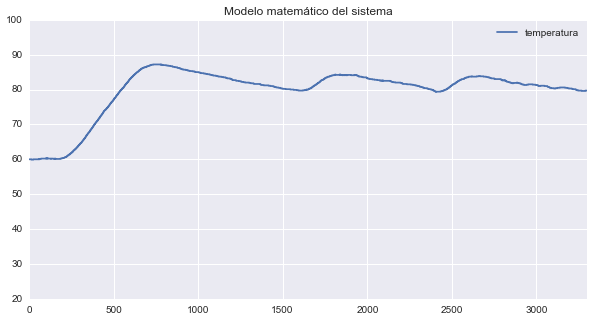

In [29]:
#Mostramos en varias gráficas la información obtenida tras el ensayo
datos[columns].plot(figsize=(10,5), ylim=(20,100),title='Modelo matemático del sistema')
#datos_filtrados['RPM TRAC'].plot(secondary_y=True,style='g',figsize=(20,20)).set_ylabel=('RPM')

Como vemos, una vez introducido el controlador, la temperatura tiende a estabilizarse, sin embargo tiene mucha sobreoscilación.